In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")
import gymnasium as gym
import numpy as np
from envs.dubins_car import DubinsCarEnv


import jax
import jax.numpy as jnp
import haiku as hk
import optax

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
jax.default_backend()

'gpu'

In [3]:
#generate data

x_s = np.linspace(-4,4, 25)
y_s = np.linspace(-4,4, 25)
theta_s = np.linspace(0,2*np.pi, 15)

xx, yy, tt = np.meshgrid(x_s, y_s, theta_s)
grid = np.vstack([xx.ravel(), yy.ravel(), tt.ravel()]).T



env = DubinsCarEnv()
state = env.reset()
X = []
y = []
for i in range(len(grid)):
    state = env.set(grid[i][0], grid[i][1], grid[i][2])
    X.append(state)

X_grid = np.array(X)
y_grid = np.array(y)
len(X_grid)


9375

In [4]:
X_grid

array([[-4.        , -4.        ,  0.        ],
       [-4.        , -4.        ,  0.44879895],
       [-4.        , -4.        ,  0.8975979 ],
       ...,
       [ 4.        ,  4.        ,  5.38558741],
       [ 4.        ,  4.        ,  5.83438636],
       [ 4.        ,  4.        ,  6.28318531]])

In [5]:


def uniform_samples(env, n):

    state = env.reset()
    X_rand = []
    for i in range(n):
        state = env.reset()
        X_rand.append(state)
        for action in range(env.action_space.n):
            next_state, reward, done, info = env.step(state, action, update_env=False)
            if info['is_legal']:
                X_rand.append(next_state)
    return np.array(X_rand)


X_samp = uniform_samples(env, 1000)
X_val = uniform_samples(env,2000)


In [6]:
X = np.vstack([X_grid])
#np.random.shuffle(X)
#X = np.flip(X,0)
len(X)

9375

In [7]:
def filter(X, get_y=None):
    filted_X = []
    for x in X:
        # calculate distance to goal and obstacle
        dist_obstacle = np.linalg.norm(x[:2] - env.obstacle_position) - env.obstacle_radius
        if dist_obstacle > 0: 

            filted_X.append(x)
    return np.array(filted_X)

#X = filter(X)

In [8]:
ys = [env.get_reward(x) for x in X]
    
ys = np.array(ys)

In [9]:
max(ys)

1

In [10]:
def plot_surface(X_in,env, file_name=None, y_pred=None, ys=None):
    %matplotlib inline

    plt.rcParams['figure.figsize'] = [15, 12]

    # Plot...
    plt.scatter(X_in[:,0], X_in[:,1], s=1) # s is a size of marker 
    plt.colorbar(label='estimated value')
    goal = plt.Circle((env.goal_position[0], env.goal_position[1]), env.min_distance_to_goal, color='g', fill=False)

    # draw obstacle
    obstacle = plt.Circle((env.obstacle_position[0], env.obstacle_position[1]), env.obstacle_radius, color='r', fill=False)
    plt.gca().add_artist(obstacle)
    plt.gca().add_artist(goal)


    arrow_len = env.v_max
    # Calculate arrow components
    arrow_dx = arrow_len * np.cos(X_in[:,2])
    arrow_dy = arrow_len * np.sin(X_in[:,2])

    if y_pred:
        arrow_colors = cm.jet((y_pred-np.min(y_pred))/(np.max(y_pred)-np.min(y_pred)))
    elif len(ys)>0:
        arrow_colors = cm.get_cmap('jet', 3)(ys+1)

    else:
        arrow_colors = 'k'


    plt.quiver(X_in[:,0], X_in[:,1], arrow_dx, arrow_dy, angles='xy', scale_units='xy', scale=1, width=0.002, color=arrow_colors)


    #plt.jet()
    #plt.show()
    if file_name:
        plt.savefig(file_name)
    #plt.show()


In [11]:
len(X)

9375

In [12]:
env.step(np.array([-2,2,np.pi]),1)

(array([-2.25      ,  2.        ,  3.14159265]), 0, False, {'is_legal': True})

/tmp/ipykernel_47154/690131176.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  arrow_colors = cm.get_cmap('jet', 3)(ys+1)


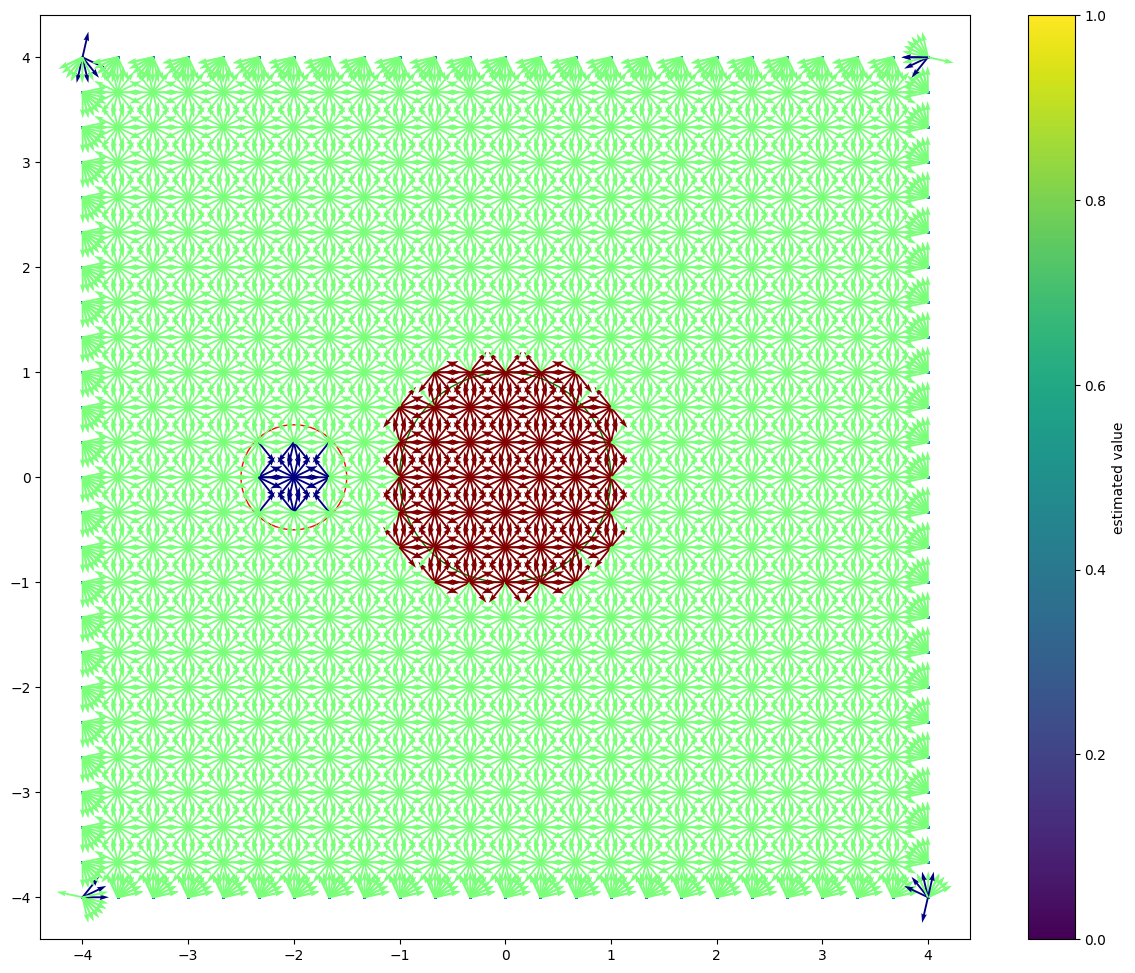

In [13]:
plot_surface(X, env, None, None, ys)

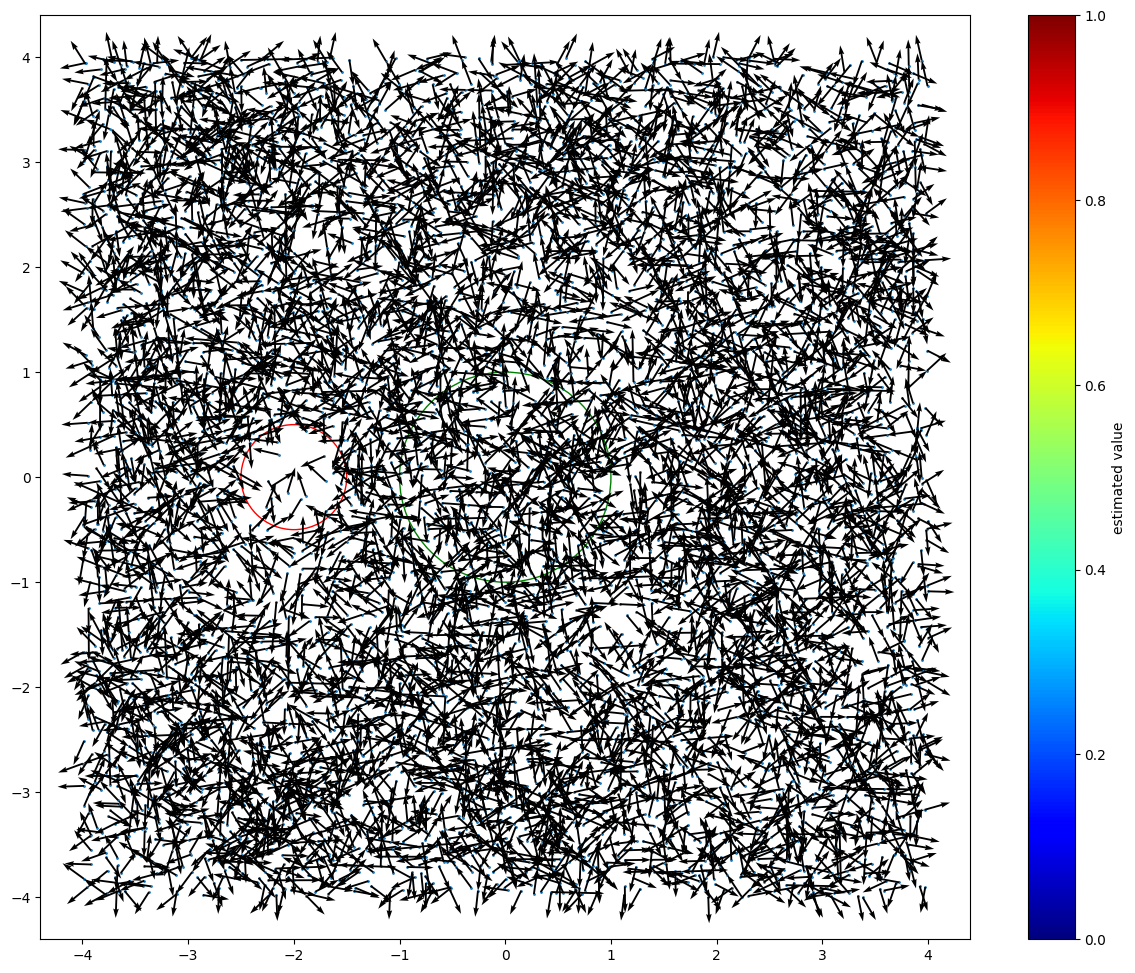

In [157]:


plot_surface(X_val, env, ys=[])

In [14]:
x_mean = np.mean(X_grid[:, 0])
x_std = np.std(X_grid[:, 0])
y_mean = np.mean(X_grid[:, 1])
y_std = np.std(X_grid[:, 1])


def normalize(X):
    X[:, 0] = (X[:, 0] - x_mean) / x_std
    X[:, 1] = (X[:, 1] - y_mean) / y_std
    return X

#X = normalize(X)

In [15]:
X3 = X.copy()
X_val3 = X_val.copy()
X = np.array(list(map(lambda row: (row[0], row[1], np.cos(row[2]), np.sin(row[2])), X)))
X_val = np.array(list(map(lambda row: (row[0], row[1], np.cos(row[2]), np.sin(row[2])), X_val)))




In [16]:
X

array([[-4.00000000e+00, -4.00000000e+00,  4.22618262e-01,
        -9.06307787e-01],
       [-4.00000000e+00, -4.00000000e+00,  7.73998108e-01,
        -6.33187909e-01],
       [-4.00000000e+00, -4.00000000e+00,  9.72078137e-01,
        -2.34657400e-01],
       ...,
       [ 4.00000000e+00,  4.00000000e+00, -6.23489802e-01,
         7.81831482e-01],
       [ 4.00000000e+00,  4.00000000e+00, -9.00968868e-01,
         4.33883739e-01],
       [ 4.00000000e+00,  4.00000000e+00, -1.00000000e+00,
         1.22464680e-16]])

In [17]:

def forward(X):
    l1 = hk.Linear(128)(X)
    l2 = jax.nn.relu(l1)
    l3 = hk.Linear(128)(l2)
    l4 = jax.nn.relu(l3)
    l5 = hk.Linear(128)(l4)
    l6 = jax.nn.relu(l5)

    l7= hk.Linear(1)(l6)

    return l7

# a transformed haiku function consists of an 'init' and an 'apply' function
forward = hk.without_apply_rng(hk.transform(forward))



# initialize parameters
rng = jax.random.PRNGKey(seed=14)
params = forward.init(rng, X)

# redefine 'forward' as the 'apply' function
forward = jax.jit(forward.apply)

# @jax.jit
# def loss_fn(params, X, y):
#     err = forward(params, X) - y
#     return jnp.mean(jnp.square(err))  # mse


l2_reg_strength = 1e-4  # Adjust this to control the strength of regularization

def l2_regularization(params):
    l2_loss = 0.0
    for param in jax.tree_leaves(params):
        if param.ndim > 1:
            l2_loss += jnp.sum(jnp.square(param))
    return l2_loss

@jax.jit
def loss_fn(params, X, y):
    err = forward(params, X) - y
    mse_loss = jnp.mean(jnp.square(err))
    l2_loss = l2_reg_strength * l2_regularization(params)
    return mse_loss + l2_loss



optimizer = optax.adamw(learning_rate=10e-5)
batch_size = 100 #make it 200
losses = [np.inf]
val_losses = [np.inf]
#check we aren't double using gradients
opt_state = optimizer.init(params)
gamma = 0.8

@jax.jit
def train_step(params, X_batch, y_batch, opt_state):
    loss, grads = jax.value_and_grad(loss_fn)(params, X=X_batch, y=y_batch)
    #updates, opt_state = optimizer.update(grads, opt_state)
    updates, opt_state = optimizer.update(grads,params=params, state= opt_state)

    params = optax.apply_updates(params, updates)
    return loss, params, opt_state

FIRST = True

for epoch in range(100):
    epoch_loss = 0.0
    opt_state = optimizer.init(params)
    for batch in range(0, len(X), batch_size):
        X_batch = X[batch:batch+batch_size]


        if FIRST:
            y_batch = ys[batch:batch+batch_size]
            #print(np.unique(y_batch, return_counts=True))
        else:
            y_batch = env.sample_value_iter(X_batch, forward, params, gamma=gamma)
        loss, params, opt_state = train_step(params, X_batch, y_batch, opt_state)
        epoch_loss += loss
    FIRST = False
    epoch_loss /= (len(X) // batch_size)

    # y_val = env.sample_value_iter(X_val, forward, params, gamma=gamma)

    # val_loss = loss_fn(params, X_val, y_val)
    # print("val_loss", val_loss, 'delta' , np.abs(val_loss - val_losses[-1]))
    # if val_losses[-1] - val_loss < 0.0001:
    #     print("early stopping",val_losses[-1] - val_loss)
    #     break
    # val_losses.append(val_loss)


    print('epoch', epoch, 'average loss', epoch_loss, 'epoch delta', np.abs(epoch_loss - losses[-1]))
    losses.append(epoch_loss)

#todo impolement val set for early stopping


2023-04-17 13:57:07.377132: W external/xla/xla/service/gpu/nvptx_compiler.cc:564] The NVIDIA driver's CUDA version is 11.7 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
/gpfs/home/apraka15/arjun/gym-env/lib/python3.9/site-packages/haiku/_src/base.py:515: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  param = init(shape, dtype)
/tmp/ipykernel_47154/3303103726.py:35: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  for param in j

epoch 0 average loss 0.11970624 epoch delta inf
epoch 1 average loss 0.08296296 epoch delta 0.036743283
epoch 2 average loss 0.08126927 epoch delta 0.0016936883
epoch 3 average loss 0.07466237 epoch delta 0.006606899
epoch 4 average loss 0.07049447 epoch delta 0.0041678995
epoch 5 average loss 0.06669382 epoch delta 0.003800653
epoch 6 average loss 0.06343116 epoch delta 0.0032626614
epoch 7 average loss 0.060726803 epoch delta 0.0027043559
epoch 8 average loss 0.058421668 epoch delta 0.0023051351
epoch 9 average loss 0.056596324 epoch delta 0.0018253438
epoch 10 average loss 0.055246513 epoch delta 0.0013498105
epoch 11 average loss 0.054173417 epoch delta 0.001073096
epoch 12 average loss 0.05328358 epoch delta 0.00088983774
epoch 13 average loss 0.052500628 epoch delta 0.0007829517
epoch 14 average loss 0.05181608 epoch delta 0.00068454817
epoch 15 average loss 0.051225238 epoch delta 0.0005908422
epoch 16 average loss 0.05071656 epoch delta 0.0005086772


KeyboardInterrupt: 

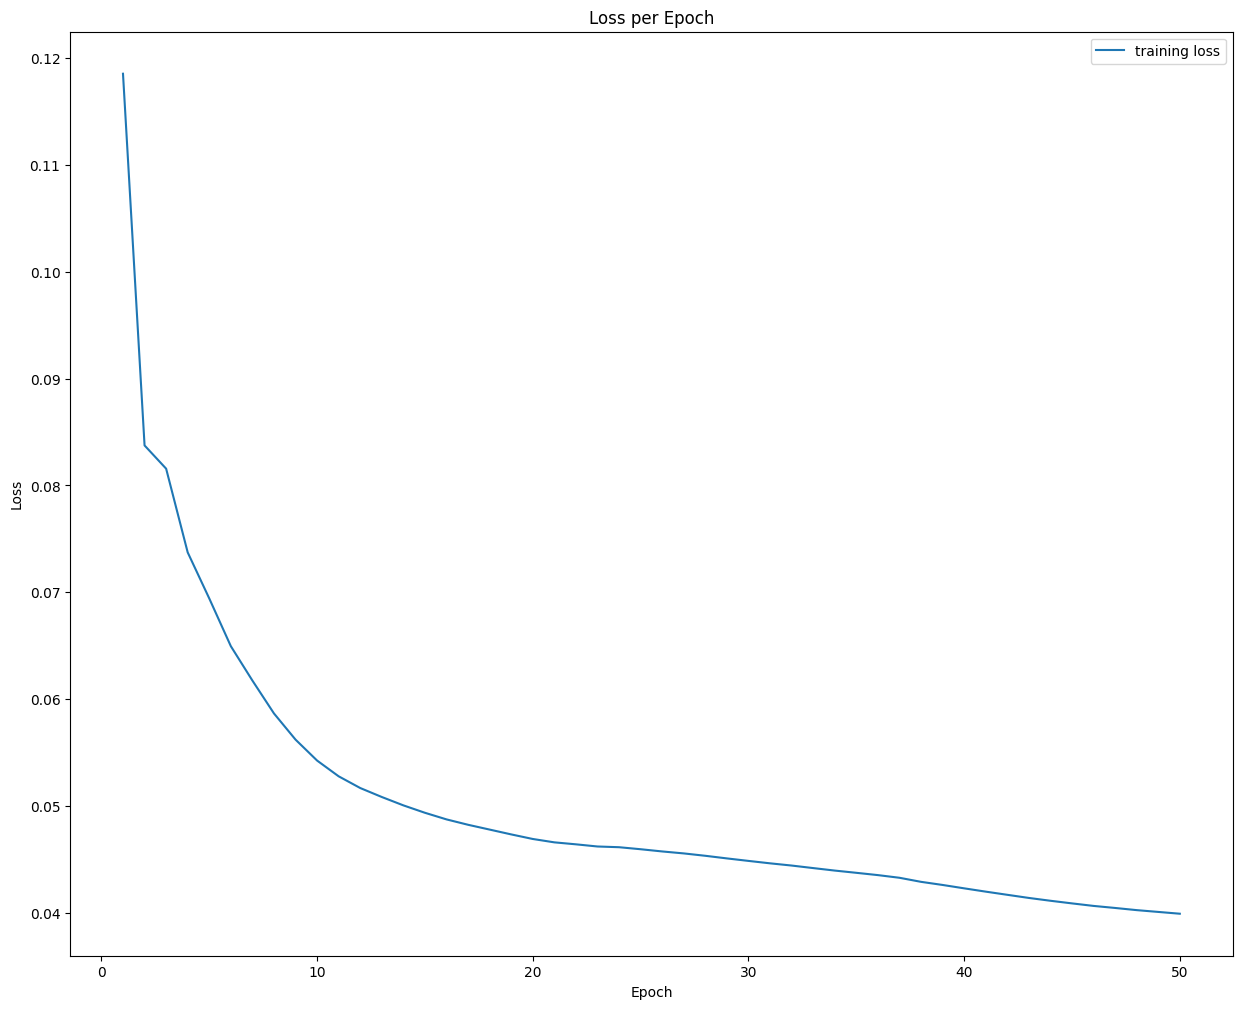

In [162]:
# Plot the losses
%matplotlib inline

lo = [l for l in losses]
#vlo = [l for l in val_losses]


plt.plot(lo, label='training loss')
#plt.plot(vlo, label='validation loss')

# Add a title and labels to the x and y axis
plt.legend()
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Show the plot
plt.savefig('losses_3.png')

plt.show()

In [163]:
#generate data

x_s = np.linspace(-5,5, 20)
y_s = np.linspace(-5,5, 20)
theta_s = np.linspace(0,2*np.pi, 15)

xx, yy, tt = np.meshgrid(x_s, y_s, theta_s)
grid_test = np.vstack([xx.ravel(), yy.ravel(), tt.ravel()]).T



env = DubinsCarEnv()
state = env.reset()
X_test = []
for i in range(len(grid_test)):
    state = env.set(grid_test[i][0], grid_test[i][1], grid_test[i][2])
    X_test.append(state)

X_test = np.array(X_test)

X_test_encoded = np.array(list(map(lambda row: (row[0], row[1], np.cos(row[2]), np.sin(row[2])), X_test)))
#X_text_encoded = normalize(X_test_encoded)
X_test_encoded

array([[-5.00000000e+00, -5.00000000e+00,  1.00000000e+00,
         0.00000000e+00],
       [-5.00000000e+00, -5.00000000e+00,  9.00968868e-01,
         4.33883739e-01],
       [-5.00000000e+00, -5.00000000e+00,  6.23489802e-01,
         7.81831482e-01],
       ...,
       [ 5.00000000e+00,  5.00000000e+00,  6.23489802e-01,
        -7.81831482e-01],
       [ 5.00000000e+00,  5.00000000e+00,  9.00968868e-01,
        -4.33883739e-01],
       [ 5.00000000e+00,  5.00000000e+00,  1.00000000e+00,
        -2.44929360e-16]])

In [171]:



y_pred = [forward(X=x, params=params) for x in X_test_encoded]

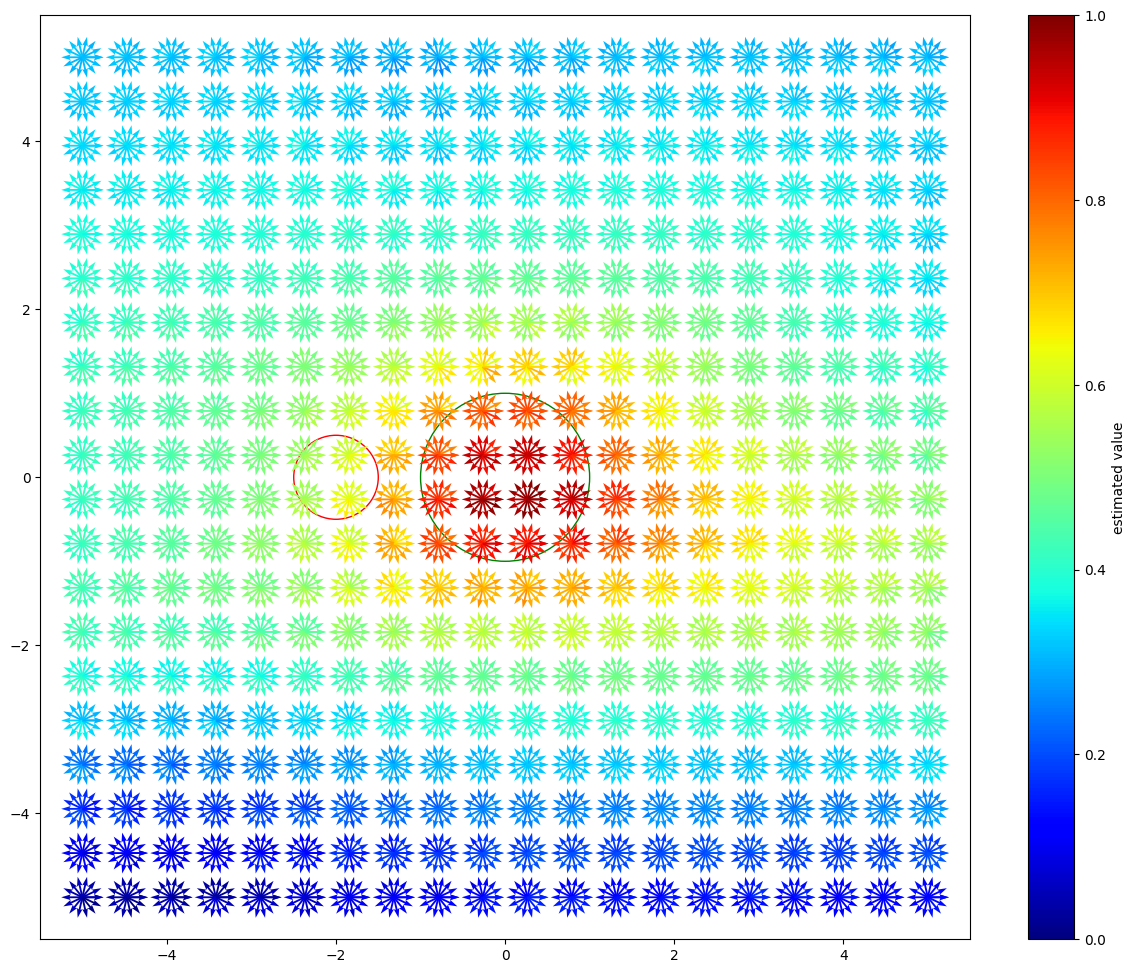

In [172]:
plot_surface(X_test, env, 'experiment.png', y_pred)

In [18]:
y_train = [forward(X=x, params=params) for x in X]

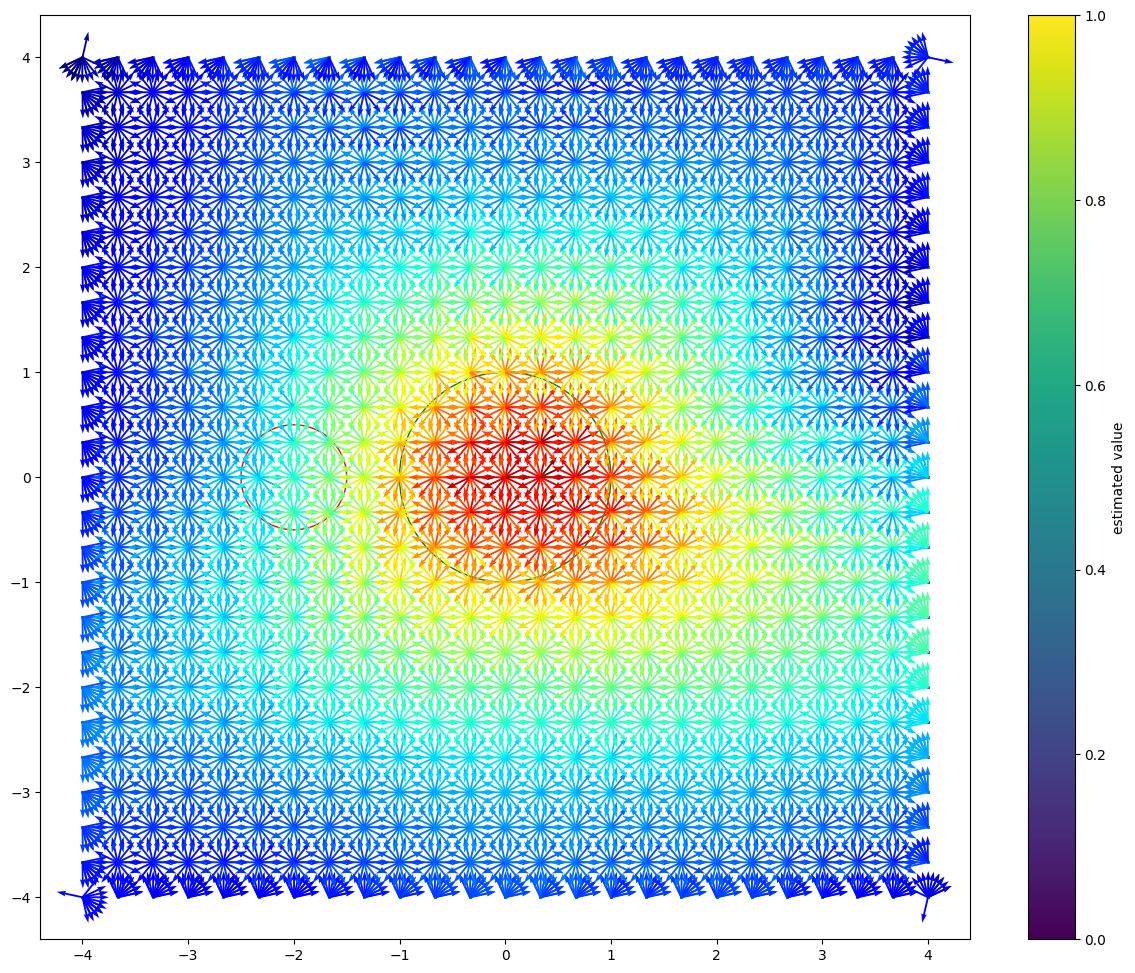

In [19]:
plot_surface(X3, env, 'experiment3.png', y_train)

In [26]:
#train on small steps, run on bigger steps?
right = 0.0
up = np.pi / 2
down = 3 * np.pi / 2
left = np.pi

env = DubinsCarEnv()
state = env.set(-3.6,0, up)
#state = env.reset()

gamma = gamma
traj = []
done = False
max_iter = 50
counter = 0
while (not done) and (counter < max_iter):
    counter+=1
    possible_actions = []
    for a in range(env.action_space.n):
        next_state, reward, done, info = env.step(state, a, update_env=False)


        if info['is_legal']:
            estimate = forward(X=np.array([next_state[0], next_state[1], np.cos(next_state[2]), np.sin(next_state[2])]), params=params)
            value = reward + gamma*estimate[0]
            possible_actions.append(value)
        else:
            possible_actions.append(-np.inf)

    print(possible_actions)
    action = np.argmax(np.array(possible_actions))
    traj.append(state)
    state, reward, done, _ = env.step(action=action, update_env=True)
    env.render()
    print(counter)
    
    
env.make_gif()

[Array(0.01928584, dtype=float32), Array(-0.03075081, dtype=float32), Array(-0.01824318, dtype=float32)]
1
[Array(0.02019289, dtype=float32), Array(0.04069613, dtype=float32), Array(-0.0189705, dtype=float32)]
2
[Array(0.03484507, dtype=float32), Array(0.06703513, dtype=float32), Array(-0.00136742, dtype=float32)]
3
[Array(0.05388818, dtype=float32), Array(0.09335259, dtype=float32), Array(0.02231725, dtype=float32)]
4
[Array(0.07529507, dtype=float32), Array(0.12077729, dtype=float32), Array(0.04877118, dtype=float32)]
5
[-inf, Array(0.14986545, dtype=float32), Array(0.07652729, dtype=float32)]
6
[-inf, Array(0.1607789, dtype=float32), Array(0.09946585, dtype=float32)]
7
[Array(0.18526572, dtype=float32), Array(0.17123461, dtype=float32), Array(0.11572045, dtype=float32)]
8
[-inf, Array(0.22350526, dtype=float32), Array(0.20534754, dtype=float32)]
9
[-inf, Array(0.2608338, dtype=float32), Array(0.24018908, dtype=float32)]
10
[-inf, Array(0.2934439, dtype=float32), Array(0.28018394, dt

In [ ]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
t = np.array([traj])
yp = [forward(X=x, params=params) for x in t]

# Plot...
plt.scatter(np.array(traj)[:,0], np.array(traj)[:,1], c=yp, s=1) # s is a size of marker 
plt.jet()
plt.colorbar()
plt.show()
#plt.savefig('500_iter.png')

ValueError: 'linear/w' with retrieved shape (4, 12) does not match shape=[3, 12] dtype=dtype('float32')

In [ ]:
10*estimate

Array([-31.93895], dtype=float32)

: 

In [ ]:
possible_actions

[Array(-12.71481, dtype=float32),
 Array(-12.356915, dtype=float32),
 Array(-12.71481, dtype=float32)]

: 

In [ ]:
np.argmax(possible_actions)

1

: 

In [ ]:
forward(X=np.array([-4,-4,1, 1]), params=params) 

Array([1.237214], dtype=float32)

In [ ]:
forward(X=np.array([0,0,1, 0]), params=params) 

Array([0.08173393], dtype=float32)

In [ ]:
env.step(np.array([0,0,np.pi]), 0, update_env=False)

(array([2.50000000e-01, 4.37113883e-08, 2.00712864e+00]), 100, True, {})

In [ ]:
X[0]

array([ 1.8830727 , -1.7482759 ,  0.23815954, -0.97122604], dtype=float32)

In [ ]:
try 90 degree turns first, try dropout or batch norm, standaridse all states, if relu add non trainable params 